# 05. MOC1 +/- Elf3 KO +/- cIFNG in vitro ATAC-seq analysis 
Elf3 -/- or Elf3+/+ MOC1 cells were treated with IFNg for one month, given a 2-week washout period, and then processed for ATAC-seq.

Additional scripts related to ATAC data pre-processing and analysis are located in `/other_scripts`.

## 0. Initial data processing

Pre-processing commands were performed on a computing cluster using the `00_atac_preprocessing.bash` script (see `/other_scripts`). Note that `00_atac_preprocessing.bash` calls `plot_insert_size.R` (saved in `/other_scripts` as `01_plot_insert_size.R`).

Counts files for DESeq2 were generated using `02_gen_counts_deseq2.sh` (see `other_scripts`).

`.bam` files were merged, normalized and converted to `.bw` files using `03_bamtobw.sh`.

Peaks were called on merged `.bam` files using `04_call_peaks_merge.sh`.

## 1. Principal components analysis

Merged counts file from all samples (`union_peak_counts.txt`) was generated using the following commands:

`cat peakfile1.narrowpeak peakfile2.narrowpeak peakfile3.narrowpeak ... peakfile8.narrowpeak > all_peaks.bed`

`bedtools sort -i all_peaks.bed > all_peaks.sorted.bed`

`bedtools merge -i all_peaks.sorted.bed > union_peaks.bed`

`bedtools multicov -bams bamfile1.bam bamfile2.bam bamfile3.bam ... bamfile8.bam -bed union_peaks.bed > union_peak_counts.txt`

PCA was performed and plotted using `05_PCA.R`.

## 2. Differential acessibility analysis with pyDESeq2

For each pair-wise comparison, the following commands were excecuted:

run DESeq2 on merged peak count matrix:

`Rscript run_deseq2.R path/to/merged_peak_counts.bed`

prepare upregulated and downregulated peaks:

`./make_bed_up.sh  # generates ifn_up_peaks_fixed.bed`

`./make_bed_down.sh  # generates ifn_down_peaks_fixed.bed`

add 4th column to `.bed` files:

`cut -f1 deseq2_results_up_significant.tsv | grep -v peak_id \`
  `| sed 's/_/\t/g' | awk '{print $1"\t"$2"\t"$3"\t"$1"_"$2"_"$3}' \`
  `> deseq2_up_peaks.bed`

`cut -f1 deseq2_results_down_significant.tsv | grep -v peak_id \`
  `| sed 's/_/\t/g' | awk '{print $1"\t"$2"\t"$3"\t"$1"_"$2"_"$3}' \`
  `> deseq2_down_peaks.bed`

activate HOMER environment:

`conda activate homer_env`

find motifs in peaks:

`findMotifsGenome.pl ifn_up_peaks_fixed.bed mm10 path/to/output/homer_up/ -size given -nomotif`
`findMotifsGenome.pl ifn_down_peaks_fixed.bed mm10 homer_ifn_down_known/ -size given -nomotif`

annotate peaks:

`annotatePeaks.pl deseq2_up_peaks.bed mm10 -size given -noadj > annotated_deseq2_up.txt`

`annotatePeaks.pl deseq2_down_peaks.bed mm10 -size given -noadj > annotated_deseq2_down.txt`


In [ ]:
# (in jupyter notebook contained within the same directory)
# create final differentially-accessibile regions file, with the following structure:
# peak_id	baseMean	log2FoldChange	lfcSE	stat	pvalue	padj	Gene Name
deseq = pd.read_csv('path/to/deseq2_results_up_significant.txt', sep='\t')
ann = pd.read_csv('path/to/annotated_deseq2_up.tsv', sep='\t')
ann = ann.rename(columns={
    "PeakID (cmd=annotatePeaks.pl deseq2_up_peaks.bed mm10 -size given -noadj)": "PeakID"
})
merged = deseq.merge(ann[["PeakID", "Gene Name"]], left_on="peak_id", right_on="PeakID", how="left").drop(columns=["PeakID"])
merged = merged.sort_values(by="stat", ascending=False)
# save fie
merged.to_csv('path/to/Up_de_genes_ann.txt', sep='\t')

annotate peaks:

`annotatePeaks.pl deseq2_up_peaks.bed mm10 -size given -noadj > annotated_deseq2_up.txt`

`annotatePeaks.pl deseq2_down_peaks.bed mm10 -size given -noadj > annotated_deseq2_down.txt`

## 3. Plot differential accessibility analyses

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from scipy.stats import zscore
import pyBigWig

### A. Plot differentially accessible regions between IFN-treated Elf3+/+ vs/ Elf3-/- cells

In [68]:
# (begin with merged differentially-accessibile regions file from above)
deseq = pd.read_csv('/path/to/deseq2_results_all.tsv', sep='\t') # produced by run_deseq2.R
deseq_up = pd.read_csv('/path/to/Up_de_genes_ann.txt', sep='\t') # produced in Jupyter notebook cell above
deseq_down = pd.read_csv('/path/to/Down_de_genes_ann.txt', sep='\t') # produced in Jupyter notebook cell above

In [69]:
# stack up and down into a single dataframe
up_down = pd.concat([deseq_up, deseq_down])

# drop duplicates
up_down = up_down.drop_duplicates(subset='peak_id')

# merge back into deseq
deseq = deseq.merge(
    up_down[['peak_id', 'Gene Name']],
    on='peak_id',
    how='left'
)

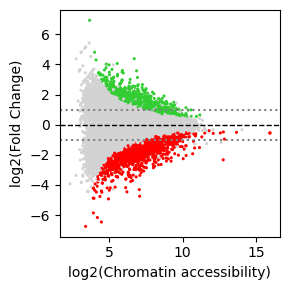

In [70]:
# calculate variables to plot and annotate file
deseq['log2_baseMean'] = np.log2(deseq['baseMean'] + 1)  # Add 1 to avoid log(0)
deseq['significant'] = deseq['padj'] < 0.01  # Define significance

# assign colors
top_color = "limegreen"        # Positive fold-change color
bottom_color = "red" # Negative fold-change color
nonsig_color = "lightgray"  # Non-significant color

# function to apply the above colors as a dataframe entry
def assign_color(row):
    if not row['significant']:
        return nonsig_color
    elif row['log2FoldChange'] > 0:
        return top_color
    else:
        return bottom_color

deseq['color'] = deseq.apply(assign_color, axis=1)

# plot
plt.figure(figsize=(3, 3))

plt.scatter(
    x=deseq['log2_baseMean'],
    y=deseq['log2FoldChange'],
    c=deseq['color'],
    s=5,
    edgecolors='none'
)

# format
plt.axhline(0, color='black', linestyle='dashed', linewidth=1)
plt.axhline(1, color='gray', linestyle='dotted')
plt.axhline(-1, color='gray', linestyle='dotted')
plt.xlabel('log2(Chromatin accessibility)')
plt.ylabel('log2(Fold Change)')

plt.legend([], [], frameon=False)

plt.tight_layout()
#plt.savefig('cIFNG_KO_diff_acc_plot.png', dpi=600)
plt.show()

In [71]:
# display values for annotated genes
deseq[deseq['Gene Name'].isin(['Cxcl1','Cxcl2', 'Cxcl5','Csf3','Il1a'])]

,peak_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene Name,log2_baseMean,significant,color
15805,chr11_98701263_98701533,105.638302,-1.158552,0.366469,-3.161392,1.570170e-03,2.648315e-02,Csf3,6.736582,False,lightgray
49423,chr2_129333507_129333844,115.623638,-1.582969,0.346970,-4.562266,5.060439e-06,3.245443e-04,Il1a,6.865716,True,red
65128,chr5_90745230_90746071,226.181623,-1.146770,0.276811,-4.142795,3.430990e-05,1.489450e-03,Cxcl5,7.827702,True,red
65141,chr5_90861886_90862671,152.500280,-1.812487,0.306714,-5.909374,3.434098e-09,7.276355e-07,Cxcl1,7.262097,True,red
65148,chr5_90881729_90882078,103.036296,-1.018644,0.341605,-2.981941,2.864276e-03,4.014102e-02,Cxcl1,6.700943,False,lightgray
65151,chr5_90902938_90903144,52.265197,-2.337514,0.497447,-4.699018,2.614155e-06,1.889003e-04,Cxcl2,5.735121,True,red


### B. Plot differentially accessible regions between MOC1(veh) and MOC1(ifn)

In [26]:
# read in differential accessibility results
deseq = pd.read_csv('/path/to/deseq2_results_all.tsv', sep='\t')
deseq_up = pd.read_csv('/path/to/Up_de_genes_ann.txt', sep='\t')
deseq_down = pd.read_csv('/path/to/Down_de_genes_ann.txt', sep='\t')
# combine into a single dataframe
up_down = pd.concat([deseq_up, deseq_down])

# drop duplicates
up_down = up_down.drop_duplicates(subset='peak_id')

# merge back into deseq
deseq = deseq.merge(
    up_down[['peak_id', 'Gene Name']],
    on='peak_id',
    how='left'
)
# keep only regions with significant signal (reduces banding pattern)
deseq = deseq[deseq["baseMean"] >= 25].copy()

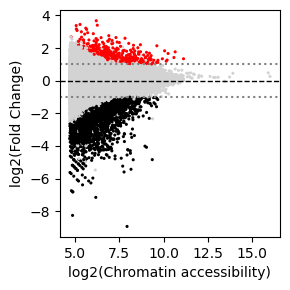

In [27]:
# calculate variables to plot and annotate file
deseq['log2_baseMean'] = np.log2(deseq['baseMean'] + 1)  # Add 1 to avoid log(0)
deseq['significant'] = deseq['padj'] < 0.01  # Define significance

# assign colors
top_color = "red"        # Positive fold-change color
bottom_color = "black" # Negative fold-change color
nonsig_color = "lightgray"  # Non-significant color

# function to apply the above colors as a dataframe entry
def assign_color(row):
    if row['padj'] < 0.01:
        if row['log2FoldChange'] > 1:
            return top_color
        elif row['log2FoldChange'] < -1:
            return bottom_color
    return nonsig_color

deseq['color'] = deseq.apply(assign_color, axis=1)

# plot
plt.figure(figsize=(3, 3))

plt.scatter(
    x=deseq['log2_baseMean'],
    y=deseq['log2FoldChange'],
    c=deseq['color'],
    s=5,
    edgecolors='none'
)

# format
plt.axhline(0, color='black', linestyle='dashed', linewidth=1)
plt.axhline(1, color='gray', linestyle='dotted')
plt.axhline(-1, color='gray', linestyle='dotted')
plt.xlabel('log2(Chromatin accessibility)')
plt.ylabel('log2(Fold Change)')
plt.legend([], [], frameon=False)
plt.tight_layout()
#plt.savefig('cIFNG_diff_acc_plot.png', dpi=400)
plt.show()

In [28]:
# display values for annotated genes
deseq[deseq['Gene Name'].isin(['Ifit3','Ifit2','Irf1','Stat1','H2-Ab1','Il1a','Cxcl1'])]

,peak_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene Name,log2_baseMean,significant,color
1087,chr1_52100465_52100864,59.461430,-2.087684,0.473294,-4.410969,1.029088e-05,5.354789e-04,Stat1,5.917943,True,black
1092,chr1_52158744_52159304,68.325299,1.467250,0.428685,3.422679,6.200732e-04,1.494639e-02,Stat1,6.115310,False,lightgray
1093,chr1_52169983_52170647,130.707424,-1.859447,0.328071,-5.667811,1.446337e-08,1.971778e-06,Stat1,7.041193,True,black
1094,chr1_52170846_52171067,41.577948,-1.965517,0.569191,-3.453175,5.540295e-04,1.377364e-02,Stat1,5.412035,False,lightgray
12972,chr11_53768711_53769187,490.831643,-1.323269,0.245055,-5.399881,6.668496e-08,7.480591e-06,Irf1,8.942021,True,black
12975,chr11_53779879_53780089,104.707507,-2.601290,0.431249,-6.031986,1.619565e-09,2.887439e-07,Irf1,6.723934,True,black
12976,chr11_53780232_53780670,310.090825,-4.849673,0.339606,-14.280293,2.903783e-46,5.197714e-42,Irf1,8.281192,True,black
12977,chr11_53781084_53782591,655.219882,-4.842255,0.247867,-19.535717,5.457359e-85,4.884282e-80,Irf1,9.358035,True,black
37139,chr17_34261654_34261948,34.718199,-2.430690,0.614454,-3.955851,7.626263e-05,2.779083e-03,H2-Ab1,5.158587,True,black
43300,chr19_34553014_34553281,30.963762,-2.564618,0.664716,-3.858215,1.142179e-04,3.867723e-03,Ifit2,4.998365,True,black


## 4. Plot browser tracks at Cxcl2 locus

In [1]:
import pandas as pd
import numpy as np
import pyBigWig
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
import pybedtools

In [2]:
# define relevant functions

def load_genes_from_gtf(gtf_file):
    """
    This function parses a GTF file to extract transcript-level gene annotations
    (chromosome, start, end, gene name or ID, and strand) and returns them as 
    a pandas DataFrame.
    """
    genes = []
    with open(gtf_file) as f:
        for line in f:
            if line.startswith('#'):
                continue
            fields = line.strip().split('\t')
            if len(fields) < 9 or fields[2] != "transcript":
                continue
            chrom = fields[0]
            start = int(fields[3])
            end = int(fields[4])
            strand = fields[6]
            attr = fields[8]
            
            gene_name = None
            for part in attr.split(';'):
                if 'gene_name' in part:
                    gene_name = part.split('"')[1]
                    break
            if gene_name is None:
                for part in attr.split(';'):
                    if 'gene_id' in part:
                        gene_name = part.split('"')[1]
                        break
            if gene_name is not None:
                genes.append((chrom, start, end, gene_name, strand))
    
    return pd.DataFrame(genes, columns=["Chr", "Start", "End", "Gene", "Strand"])

def load_peaks(bed_file):
    """
    This function reads a BED file and returns a pandas DataFrame containing the 
    chromosome, start, and end coordinates of each peak.
    """
    return pd.read_csv(bed_file, sep='\t', header=None, usecols=[0, 1, 2], names=["Chr", "Start", "End"])

def plot_genes(ax, genes_df, chrom, start, end, font_size=8):
    """
    This function plots stores gene information to annotate browser tracks.
    """
    region_genes = genes_df[
        (genes_df["Chr"] == chrom) &
        (genes_df["Start"] < end) &
        (genes_df["End"] > start)
    ]

def plot_bigwig_filled(ax, bw_file, chrom, start, end, color='black', label=None, ymax=None):
    """
    This function plots signal data from a BigWig file.
    """
    bw = pyBigWig.open(bw_file)
    values = bw.values(chrom, start, end, numpy=True)
    bw.close()
    
    # replace NaNs with zeros
    values = np.nan_to_num(values, nan=0.0)
    
    x = np.arange(start, start + len(values))
    
    ax.fill_between(x, values, step='mid', color=color, alpha=0.6, label=label)
    ax.set_xlim(start, end)
    if ymax is not None:
        ax.set_ylim(0, ymax)
    ax.set_ylabel('Signal')

def get_bigwig_max(bw_file, chrom, start, end):
    """
    Return the maximum signal value in a BigWig file over a given region 
    (for automating y-axis max value).
    """
    bw = pyBigWig.open(bw_file)
    values = bw.values(chrom, start, end, numpy=True)
    bw.close()
    values = np.nan_to_num(values, nan=0.0)
    return np.max(values)

def plot_bigwigs_filled_with_genes(bigwig_files_dict, genes_df, chrom, start, end,
                                   bigwig_colors=None, figsize=(4, 6), font_size=8,
                                   save_path=None, dpi=300):
    """
    Plot BigWig tracks (filled) + gene annotations, with minimal space between tracks.
    Optionally save to file.
    """
    bigwig_labels = list(bigwig_files_dict.keys())
    bigwig_paths = list(bigwig_files_dict.values())
    num_tracks = len(bigwig_labels)
    
    # find global ymax with 5% buffer on top
    ymax = 0
    for path in bigwig_paths:
        ymax = max(ymax, get_bigwig_max(path, chrom, start, end))
    ymax *= 1.05
    
    # create figure and tight layout
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(num_tracks + 1, 1, height_ratios=[1]*num_tracks + [0.5], hspace=0.05)
    
    if bigwig_colors is None:
        bigwig_colors = ['black'] * num_tracks
    
    axes = [fig.add_subplot(gs[i, 0]) for i in range(num_tracks + 1)]

    # plot tracks
    for ax, label, path, color in zip(axes[:-1], bigwig_labels, bigwig_paths, bigwig_colors):
        plot_bigwig_filled(ax, path, chrom, start, end, color=color, label=label, ymax=ymax)
        ax.set_yticks([0, round(ymax, 1)])
        ax.tick_params(axis='y', labelsize=font_size)
        ax.spines['left'].set_visible(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])  # No x-ticks

    plot_genes(axes[-1], genes_df, chrom, start, end, font_size=font_size)
    axes[-1].set_xlabel(f'{chrom}:{start}-{end}', fontsize=font_size)
    
    # save (optional)
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    plt.show()

In [8]:
# read in and format files
# GTF for annotations
GTF = "/path/to/mm10.refGene.gtf"
# BigWig files
BIGWIG_FILES = {
"MOC1ifn": "/path/to/MOC1ifn_merged.bw",
 "KOifn": "/path/to/KOifn_merged.bw",
  "MOC1veh": "/path/to/MOC1veh_merged.bw", 
    "KOveh": "/path/to/KOveh_merged.bw"
}
# import gene annotations locally
genes_df = load_genes_from_gtf(GTF)

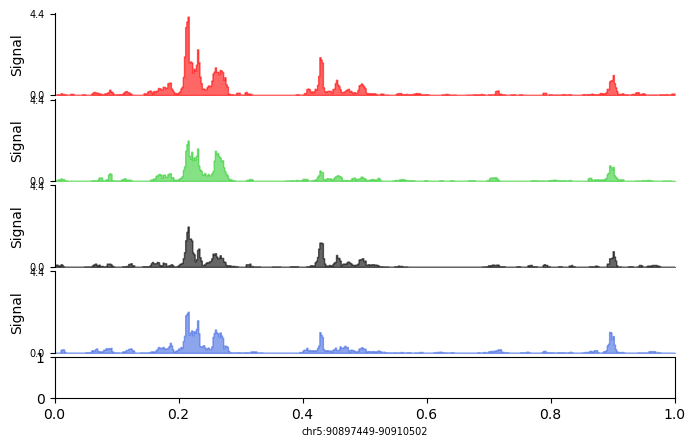

In [9]:
plot_bigwigs_filled_with_genes(
    BIGWIG_FILES,
    genes_df,
    chrom="chr5",
    start=90897449,
    end=90910502,
    bigwig_colors=['red', 'limegreen', 'black', 'royalblue'],
    figsize=(8, 5),
    font_size=7,
    #save_path="xxx.png", dpi=600
)

# 5. Motif enrichment plots

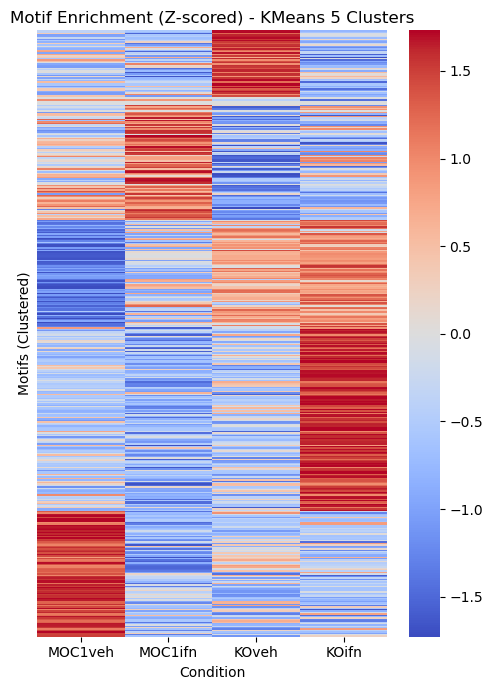


Cluster 0 (48 motifs shown: 10):
  - RUNX1(Runt)/Jurkat-RUNX1-ChIP-Seq(GSE29180)/Homer
  - p73(p53)/Trachea-p73-ChIP-Seq(PRJNA310161)/Homer
  - GRHL2(CP2)/HBE-GRHL2-ChIP-Seq(GSE46194)/Homer
  - Ronin(THAP)/ES-Thap11-ChIP-Seq(GSE51522)/Homer
  - GFY-Staf(?,Zf)/Promoter/Homer
  - Bcl11a(Zf)/HSPC-BCL11A-ChIP-Seq(GSE104676)/Homer
  - Smad2(MAD)/ES-SMAD2-ChIP-Seq(GSE29422)/Homer
  - FOXP1(Forkhead)/H9-FOXP1-ChIP-Seq(GSE31006)/Homer
  - OCT:OCT-short(POU,Homeobox)/NPC-OCT6-ChIP-Seq(GSE43916)/Homer
  - Gfi1b(Zf)/HPC7-Gfi1b-ChIP-Seq(GSE22178)/Homer

Cluster 1 (89 motifs shown: 10):
  - p63(p53)/Keratinocyte-p63-ChIP-Seq(GSE17611)/Homer
  - p53(p53)/Saos-p53-ChIP-Seq/Homer
  - p53(p53)/Saos-p53-ChIP-Seq(GSE15780)/Homer
  - Fli1(ETS)/CD8-FLI-ChIP-Seq(GSE20898)/Homer
  - GABPA(ETS)/Jurkat-GABPa-ChIP-Seq(GSE17954)/Homer
  - ETV1(ETS)/GIST48-ETV1-ChIP-Seq(GSE22441)/Homer
  - NF1(CTF)/LNCAP-NF1-ChIP-Seq(Unpublished)/Homer
  - Elf4(ETS)/BMDM-Elf4-ChIP-Seq(GSE88699)/Homer
  - EHF(ETS)/LoVo-EHF-ChIP-S

In [16]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# load homer motif results
homer_files = {
    'MOC1veh': '/path/to/MOC1veh_motifs/knownResults.txt',
    'MOC1ifn': '/path/to/MOC1ifn_motifs/knownResults.txt',
    'KOveh': '/path/to/KOveh_motifs/knownResults.txt',
    'KOifn': '/path/to/KOifn_motifs/knownResults.txt'
}

dfs = {}
# read in motif enrichment
for cond, file in homer_files.items():
    df = pd.read_csv(file, sep='\t')
    # compute -log10(q-value)
    df['-log10_qvalue'] = -df['Log P-value']
    
    # keep only the strongest match for each motif
    df = df.sort_values('-log10_qvalue', ascending=False).drop_duplicates('Motif Name')
    # store a Series of -log10(q-value) values indexed by motif name
    dfs[cond] = df.set_index('Motif Name')['-log10_qvalue']

# combine all motifs across conditions
combined = pd.concat(dfs, axis=1)
combined.columns = combined.columns.get_level_values(0)
combined = combined.fillna(0)

# take row-wise Z-score
combined_z = pd.DataFrame(
    zscore(combined, axis=1, nan_policy='omit'),
    index=combined.index,
    columns=combined.columns
)

combined_z = combined_z.fillna(0)

# perform K means clustering
K = 5
kmeans = KMeans(n_clusters=K, random_state=42)
cluster_labels = kmeans.fit_predict(combined_z)

combined_z['Cluster'] = cluster_labels

# plot heatmap
combined_z_sorted = combined_z.sort_values('Cluster')

plt.figure(figsize=(5, 7))
sns.heatmap(
    combined_z_sorted.drop(columns='Cluster'),
    cmap='coolwarm', 
    center=0,
    yticklabels=False
)
plt.title(f'Motif Enrichment (Z-scored) - KMeans {K} Clusters')
plt.xlabel('Condition')
plt.ylabel('Motifs (Clustered)')
plt.tight_layout()
#plt.savefig('heatmap_all_motifs.png', dpi=600)
plt.show()

# output the top motifs beloning to each cluster
for cluster in sorted(combined_z['Cluster'].unique()):
    motifs = combined_z[combined_z['Cluster'] == cluster].index.tolist()
    print(f"\nCluster {cluster} ({len(motifs)} motifs shown: {min(len(motifs), 10)}):")
    for m in motifs[:10]:
        print(f"  - {m}")

/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_73330/23491487.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


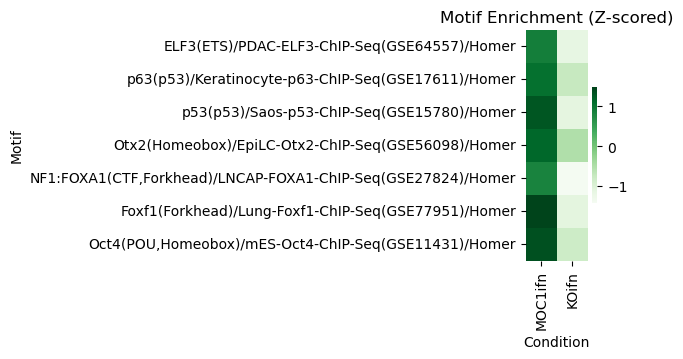

In [15]:
# plot slected motifs heatmap
# specify input motifs to plot

motifs_to_plot = [
    'ELF3(ETS)/PDAC-ELF3-ChIP-Seq(GSE64557)/Homer',
    'p63(p53)/Keratinocyte-p63-ChIP-Seq(GSE17611)/Homer',
    'p53(p53)/Saos-p53-ChIP-Seq(GSE15780)/Homer',
    'Otx2(Homeobox)/EpiLC-Otx2-ChIP-Seq(GSE56098)/Homer',
    'NF1:FOXA1(CTF,Forkhead)/LNCAP-FOXA1-ChIP-Seq(GSE27824)/Homer',
    'Foxf1(Forkhead)/Lung-Foxf1-ChIP-Seq(GSE77951)/Homer',
    'Oct4(POU,Homeobox)/mES-Oct4-ChIP-Seq(GSE11431)/Homer'
]

# read in and format p values and motif names (same as above)
dfs = {}

for cond, file in homer_files.items():
    df = pd.read_csv(file, sep='\t')
    df['-log10_qvalue'] = -df['Log P-value']
    df = df[df['Motif Name'].isin(motifs_to_plot)]
    dfs[cond] = df.set_index('Motif Name')['-log10_qvalue']
    
# combine all replicates
combined = pd.concat(dfs, axis=1)
combined.columns = combined.columns.get_level_values(0)
combined = combined.fillna(0)

# row-wise Z-score
combined_z = pd.DataFrame(
    zscore(combined, axis=1),
    index=combined.index,
    columns=combined.columns
)

# apply custom ordering
combined_z = combined_z.reindex(motifs_to_plot)

# subset to only MOC1(IFN) and Elf3 KO(IFN)
combined_z_sub = combined_z[['MOC1ifn', 'KOifn']]

# plot heatmap
plt.figure(figsize=(1, 3))
sns.heatmap(combined_z_sub, cmap='Greens', center=0, annot=False, fmt=".2f", cbar_kws={"shrink": 0.5})
plt.title('Motif Enrichment (Z-scored)')
plt.ylabel('Motif')
plt.xlabel('Condition')
plt.tight_layout()
#plt.savefig('motif_heatmap.png', dpi=600)

plt.show()